In [1]:
import argparse
import os
import numpy as np
import time
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

from dataset import *
from model import *
from utils import *

class_num = 4 #cat dog person background

num_epochs = 30
batch_size = 32


boxs_default = default_box_generator([10,5,3,1], [0.2,0.4,0.6,0.8], [0.1,0.3,0.5,0.7])


#Create network
network = SSD(class_num)
network.cuda()
cudnn.benchmark = True

/home/mka219/.conda/envs/image_segmentation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load = True
if load:
  print('loading model')
  network.load_state_dict(torch.load('network_3feb.pth'))


loading model


In [3]:

dataset = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = "True", image_size=320)
#dataset_test = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = False, image_size=320)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = optim.Adam(network.parameters(), lr = 1e-4)


Training


In [4]:
len(dataloader)

180

[0] time: 43.924704 train loss: 1.081101


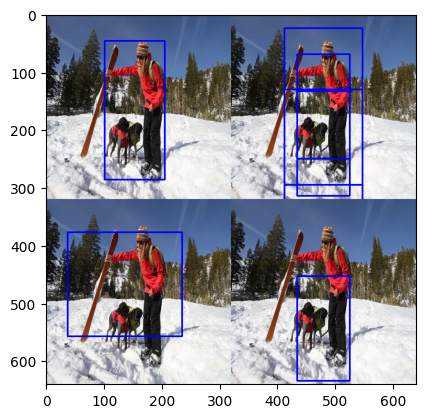

[1] time: 88.805704 train loss: 1.082131


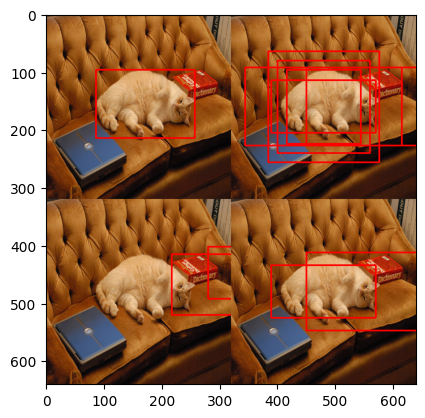

[2] time: 134.309458 train loss: 1.081879


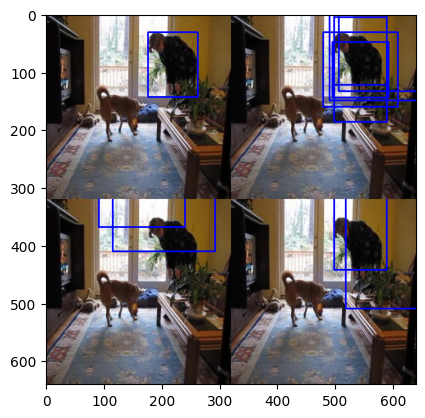

[3] time: 180.300578 train loss: 1.081151


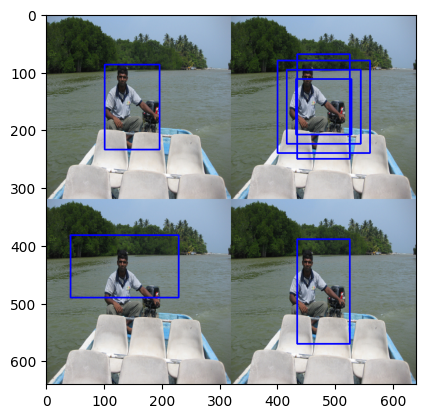

[4] time: 226.436513 train loss: 1.079902


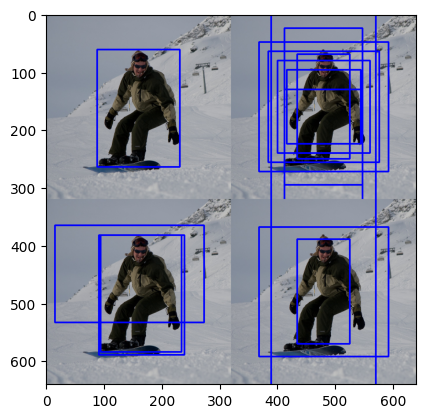

[5] time: 272.616960 train loss: 1.078685


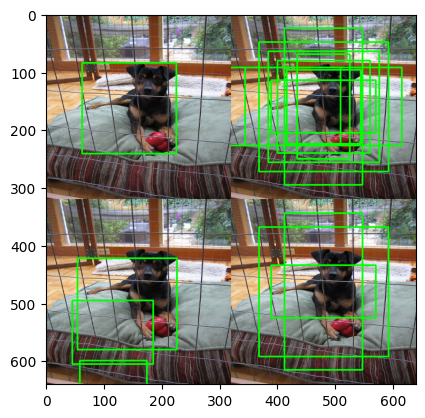

In [6]:

#feel free to try other optimizers and parameters.

start_time = time.time()

for epoch in range(num_epochs):
    #TRAINING
    network.train()

    avg_loss = 0
    avg_count = 0
    for i, data in enumerate(dataloader, 0):
        images_, ann_box_, ann_confidence_ = data
        images = images_.cuda()
        img = images_[0].numpy()
        #img = np.transpose(img, (1,2,0))
        #cv2.imshow(" check ",np.transpose(img, (1,2,0)))
        #cv2.waitKey(1)
        ann_box = ann_box_.cuda()
        ann_confidence = ann_confidence_.cuda()

        optimizer.zero_grad()
        #print(" before model", time.time()-start_time)
        pred_confidence, pred_box = network(images)
        #print("after model", time.time()-start_time)
        loss_net = SSD_loss(pred_confidence, pred_box, ann_confidence, ann_box)
        loss_net.backward()
        optimizer.step()
        
        avg_loss += loss_net.data
        avg_count += 1
        #break
        #if i==10:
            #break

    print('[%d] time: %f train loss: %f' % (epoch, time.time()-start_time, avg_loss/avg_count))
    
    #visualize
    pred_confidence_ = pred_confidence[0].detach().cpu().numpy()
    pred_box_ = pred_box[0].detach().cpu().numpy()
    pred_box_, pred_confidence_, ogn_pred_box = non_maximum_suppression(pred_box_, pred_confidence_, boxs_default)
    visualize_pred("train", pred_confidence_, pred_box_, ann_confidence_[0].numpy(), ann_box_[0].numpy(), images_[0].numpy(), boxs_default, ogn_pred_box)
    
    
    #VALIDATION
    network.eval()
    
    #optional: compute F1
    #F1score = 2*precision*recall/np.maximum(precision+recall,1e-8)
    #print(F1score)
    
    #save weights
    if epoch%10==9:
        #save last network
        print('saving net...')
        torch.save(network.state_dict(), 'network_3feb.pth')
    #break


